A routine to test OBIWAN on the COMP6v2 benchmark suite.

In [1]:
%cd ../..

/Users/stefanomartire/GitHub/OBIWAN_main


In [2]:
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json

In [3]:
from data import datasetting
from architectures import net_utils

In [4]:
import torchani
import torch

# COMP6v2 visualization

In [5]:
def cardinalityAndMaxSizeMeter(dataset):

    max_size = 0
    cardinality = 0

    for (coords, species), energy in iter(dataset):
        size = species.shape[0]
        if size > max_size:
            max_size = size
        cardinality += 1

    return cardinality, max_size

In [6]:
ds_path_list = glob.glob("data/datasets/comp6v2/*.h5")

In [7]:
ds_generator_list = [datasetting.COMP6v2Yielder(ds_path) for ds_path in ds_path_list]
ds_properties_list = [cardinalityAndMaxSizeMeter(ds) for ds in ds_generator_list]

In [8]:
ds_properties_dict = {
                        "-".join(ds_path.split("/")[-1].split(".")[0].split("-")[0:2]):
                            {"cardinality":cardinality, "max_size":max_size}
                        for ds_path, (cardinality, max_size) in zip(ds_path_list, ds_properties_list)
                        }

In [9]:
df = pd.DataFrame(ds_properties_dict)
df

,GDB-heavy11,S66x8-v1,GDB-heavy10,GDB-heavy07,DrugBank-SFCl,GDB-heavy08,GDB-heavy09,Tripeptides-v1,GDB11-08,DrugBank-testset,ANI-BenchMD,GDB11-07,GDB11-09,GDB11-11,GDB13-12,GDB13-13,GDB11-10,Tripeptides-sulphur
cardinality,9000,528,9000,9000,9824,9000,9000,1984,12000,13379,1791,12000,12000,11670,12000,12000,12000,1552
max_size,31,34,28,21,107,23,24,69,26,140,312,23,27,32,36,38,29,63


# The tests

## OBI

In [10]:
checkpoint_path = "results/models/obiwan_ani1Uani2_FH_VL_2.404"
model_name = "obiwan"

In [11]:
obiwan = net_utils.getModel(model_name=model_name, weights=checkpoint_path)

In [12]:
obiwan_dict = {}

In [13]:
for ds_path in ds_path_list:

    ds_name = "-".join(ds_path.split("/")[-1].split(".")[0].split("-")[0:2])

    # Compute/get the list of errors
    try:
        with open(f"results/test_COMP6v2/squared_errors/{model_name}_{ds_name}.json", "r") as f:
            squared_errors_list = json.load(f)
    except:
        squared_errors_list = datasetting.OBITestOnCOMP6v2(ds_path=ds_path, model=obiwan)
        with open(f"results/test_COMP6v2/squared_errors/{model_name}_{ds_name}.json", "w") as f:
            json.dump(squared_errors_list, f)

    # Store the errors
    obiwan_dict[ds_name] = squared_errors_list

## ANI

In [14]:
model_name = "anakin"

In [15]:
anakin = torchani.models.ANI2x(periodic_table_index=True, model_index=0)

In [16]:
anakin_dict = {}

In [17]:
for ds_path in ds_path_list:

    ds_name = "-".join(ds_path.split("/")[-1].split(".")[0].split("-")[0:2])

    # Compute/get the list of errors
    try:
        with open(f"results/test_COMP6v2/squared_errors/{model_name}_{ds_name}.json", "r") as f:
            squared_errors_list = json.load(f)
    except:
        squared_errors_list = datasetting.ANITestOnCOMP6v2(ds_path=ds_path, model=anakin)
        with open(f"results/test_COMP6v2/squared_errors/{model_name}_{ds_name}.json", "w") as f:
            json.dump(squared_errors_list, f)

    # Store the errors
    anakin_dict[ds_name] = squared_errors_list

At this point we have dicts of squared, hartree errors.

# Visualise the results

## RMSE dataframe

In [18]:
def kcalmolRMSE(squared_errors_list):
    rmse = np.sqrt(np.mean(squared_errors_list))
    rmse = net_utils.hartree2kcalmol(rmse)
    return rmse

In [19]:
obiwan_rmse_dict = {ds_name:kcalmolRMSE(obiwan_dict[ds_name]) for ds_name in obiwan_dict}
obiwan_rmse_dict["model"] = "obiwan"

anakin_rmse_dict = {ds_name:kcalmolRMSE(anakin_dict[ds_name]) for ds_name in anakin_dict}
anakin_rmse_dict["model"] = "ANI-2x[0]"

In [20]:
rmse_dataframe = pd.DataFrame([anakin_rmse_dict, obiwan_rmse_dict])
rmse_dataframe = rmse_dataframe[["model"] + sorted([col for col in rmse_dataframe.columns if col != "model"])]

In [21]:
rmse_dataframe['mean'] = rmse_dataframe.drop(['model', 'ANI-BenchMD'], axis=1).mean(axis=1)

In [22]:
rmse_dataframe

,model,ANI-BenchMD,DrugBank-SFCl,DrugBank-testset,GDB-heavy07,GDB-heavy08,GDB-heavy09,GDB-heavy10,GDB-heavy11,GDB11-07,GDB11-08,GDB11-09,GDB11-10,GDB11-11,GDB13-12,GDB13-13,S66x8-v1,Tripeptides-sulphur,Tripeptides-v1,mean
0,ANI-2x[0],5.764198,5.711286,4.122085,0.956557,1.211165,1.494669,1.870688,2.616729,1.110780,1.383600,1.787663,2.186734,2.927868,3.46365,4.102762,0.662565,2.936996,3.004613,2.444142
1,obiwan,15.250873,6.888181,6.092398,1.134538,1.385791,2.025050,2.358456,3.310388,1.122207,1.357227,1.681586,2.214348,2.990135,3.72500,4.543472,0.786139,3.088295,4.465186,2.892259


## RMSE bars

In [23]:
rmse_dataframe = rmse_dataframe.set_index('model').drop(['ANI-BenchMD'], axis=1)

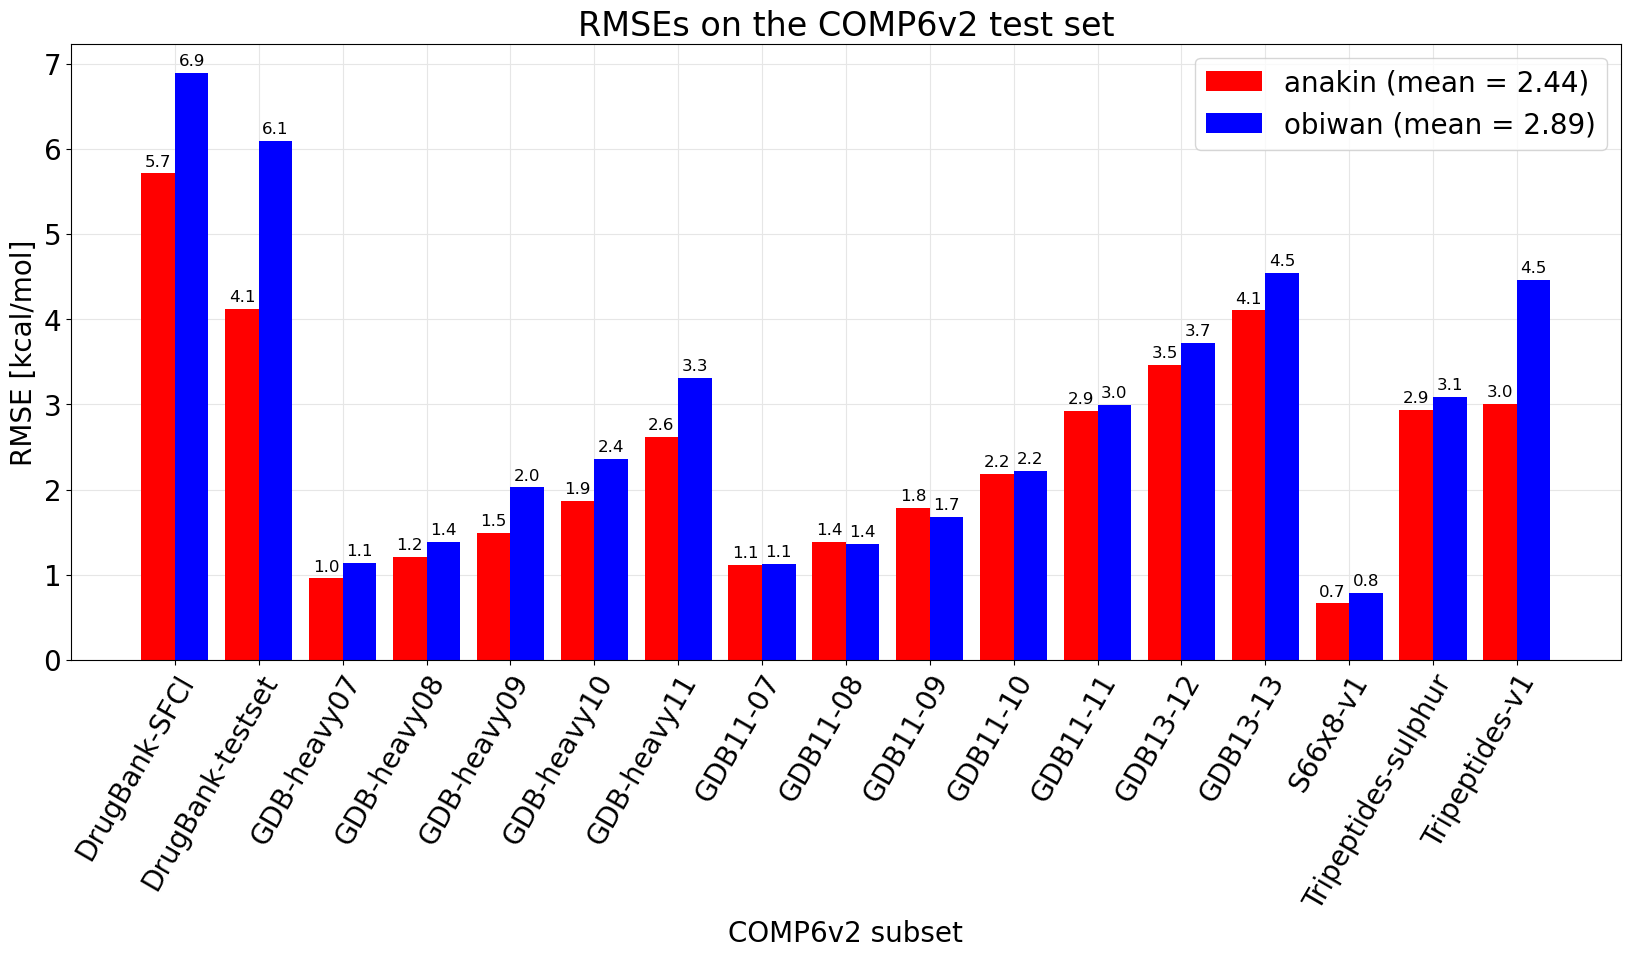

In [24]:
anakin_mean = rmse_dataframe.loc['ANI-2x[0]']['mean']
obiwan_mean = rmse_dataframe.loc['obiwan']['mean']

anakin_legend = f'anakin (mean = {anakin_mean:.2f})'
obiwan_legend = f'obiwan (mean = {obiwan_mean:.2f})'

rmse_dataframe = rmse_dataframe.drop(['mean'], axis=1)

anakin_bars = rmse_dataframe.loc['ANI-2x[0]'].to_numpy()
obiwan_bars = rmse_dataframe.loc['obiwan'].to_numpy()

x_ticks = rmse_dataframe.columns

plt.rc('font', size=20)

x_axis = np.arange(len(x_ticks))

plt.bar(x=x_axis-0.2, height=anakin_bars, width=0.4, label=anakin_legend, color='red', zorder=2)
plt.bar(x=x_axis+0.2, height=obiwan_bars, width=0.4, label=obiwan_legend, color='blue', zorder=2)

for i, v in enumerate(anakin_bars):
    plt.text(i-0.2, v + 0.05, f'{v:.1f}', ha='center', va='bottom', fontsize=12)

for i, v in enumerate(obiwan_bars):
    plt.text(i+0.2, v + 0.05, f'{v:.1f}', ha='center', va='bottom', fontsize=12)

plt.xticks(x_axis, x_ticks, rotation=60, ha='right', rotation_mode='anchor')
plt.xlabel('COMP6v2 subset')
plt.ylabel('RMSE [kcal/mol]')

plt.title('RMSEs on the COMP6v2 test set')

plt.legend()

plt.grid(color='0.9', zorder=1)

fig = plt.gcf()
fig.set_size_inches(20, 8)

In [25]:
max_y = max(rmse_dataframe.loc['obiwan'].max(), rmse_dataframe.loc['ANI-2x[0]'].max())  # for later

## Errors distribution and outliers

In [26]:
obiwan_errors_dict = {
                        ds_name : net_utils.hartree2kcalmol(np.sqrt(obiwan_dict[ds_name]))
                        for ds_name in obiwan_dict
                    }
anakin_errors_dict = {
                        ds_name : net_utils.hartree2kcalmol(np.sqrt(anakin_dict[ds_name]))
                        for ds_name in anakin_dict
                    }

In [27]:
obiwan_errors_dict = {k: obiwan_errors_dict[k] for k in sorted(obiwan_errors_dict)}
anakin_errors_dict = {k: anakin_errors_dict[k] for k in sorted(anakin_errors_dict)}

del obiwan_errors_dict["ANI-BenchMD"]
del anakin_errors_dict["ANI-BenchMD"]

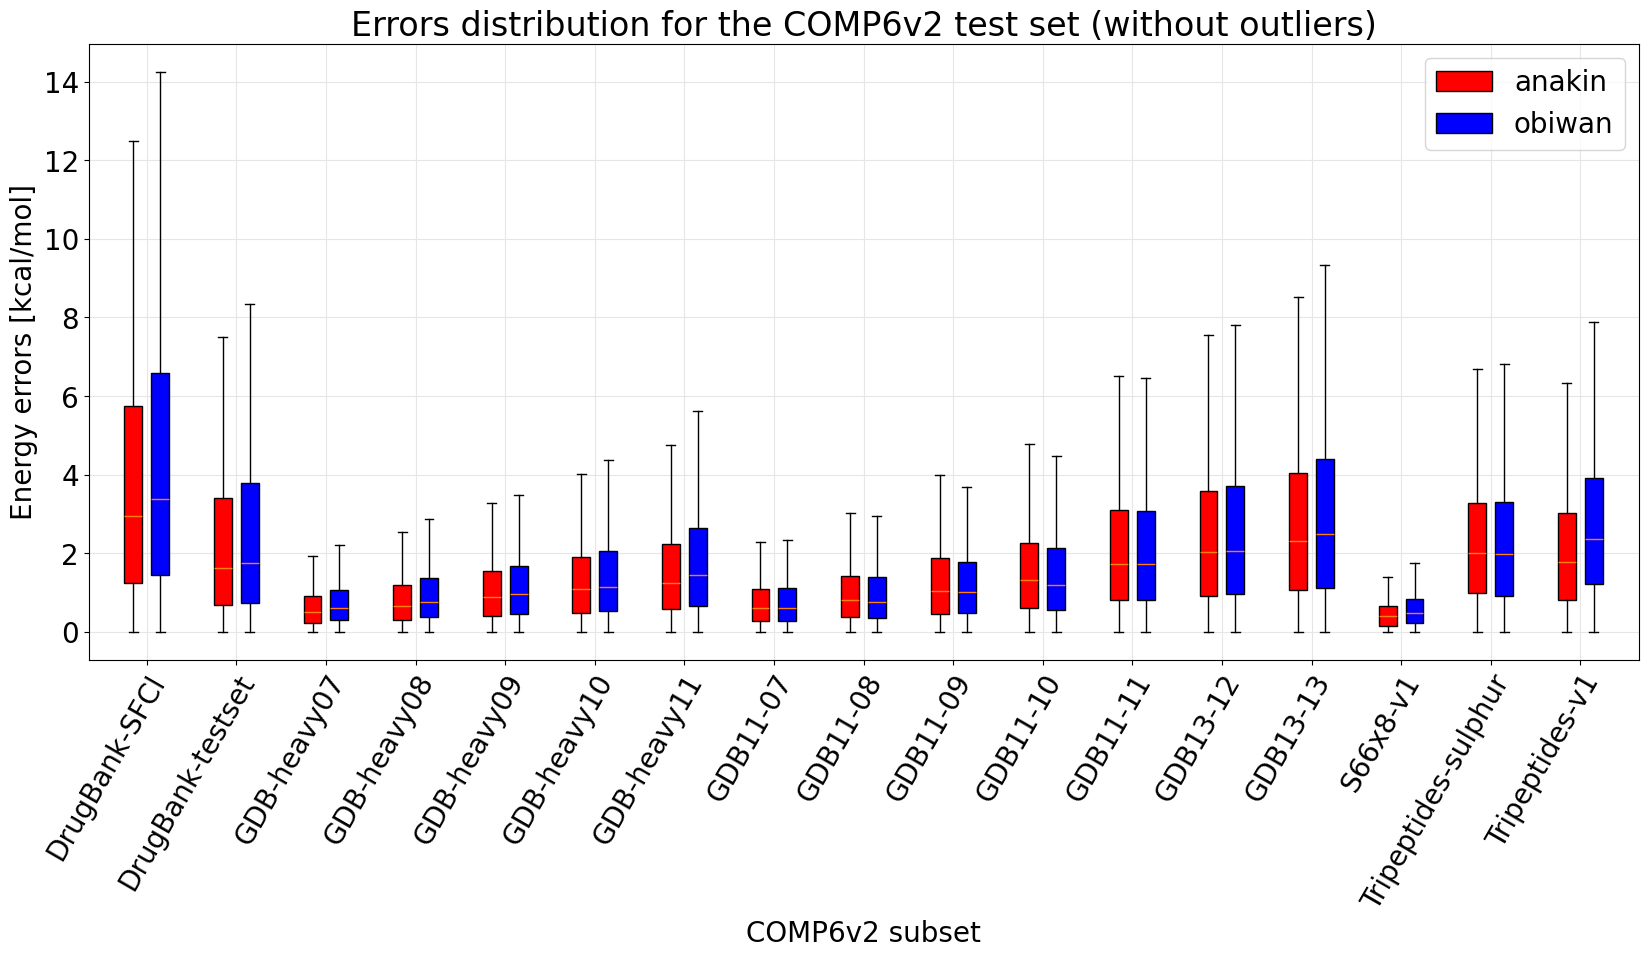

In [28]:
show_outliers = False

obi_box = plt.boxplot(obiwan_errors_dict.values(), positions=np.arange(len(obiwan_errors_dict))+0.15, widths=0.2, showfliers=show_outliers, patch_artist=True, boxprops=dict(facecolor='blue'))
ani_box = plt.boxplot(anakin_errors_dict.values(), positions=np.arange(len(anakin_errors_dict))-0.15, widths=0.2, showfliers=show_outliers, patch_artist=True, boxprops=dict(facecolor='red'))

plt.xticks(np.arange(len(obiwan_errors_dict)), obiwan_errors_dict.keys(), rotation=60, ha='right', rotation_mode='anchor')

plt.xlabel('COMP6v2 subset')
plt.ylabel('Energy errors [kcal/mol]')
plt.title('Errors distribution for the COMP6v2 test set (without outliers)')

plt.legend([ani_box["boxes"][0], obi_box["boxes"][0]], ['anakin', 'obiwan'])
plt.grid(color='0.9')

fig = plt.gcf()
fig.set_size_inches(20, 8)

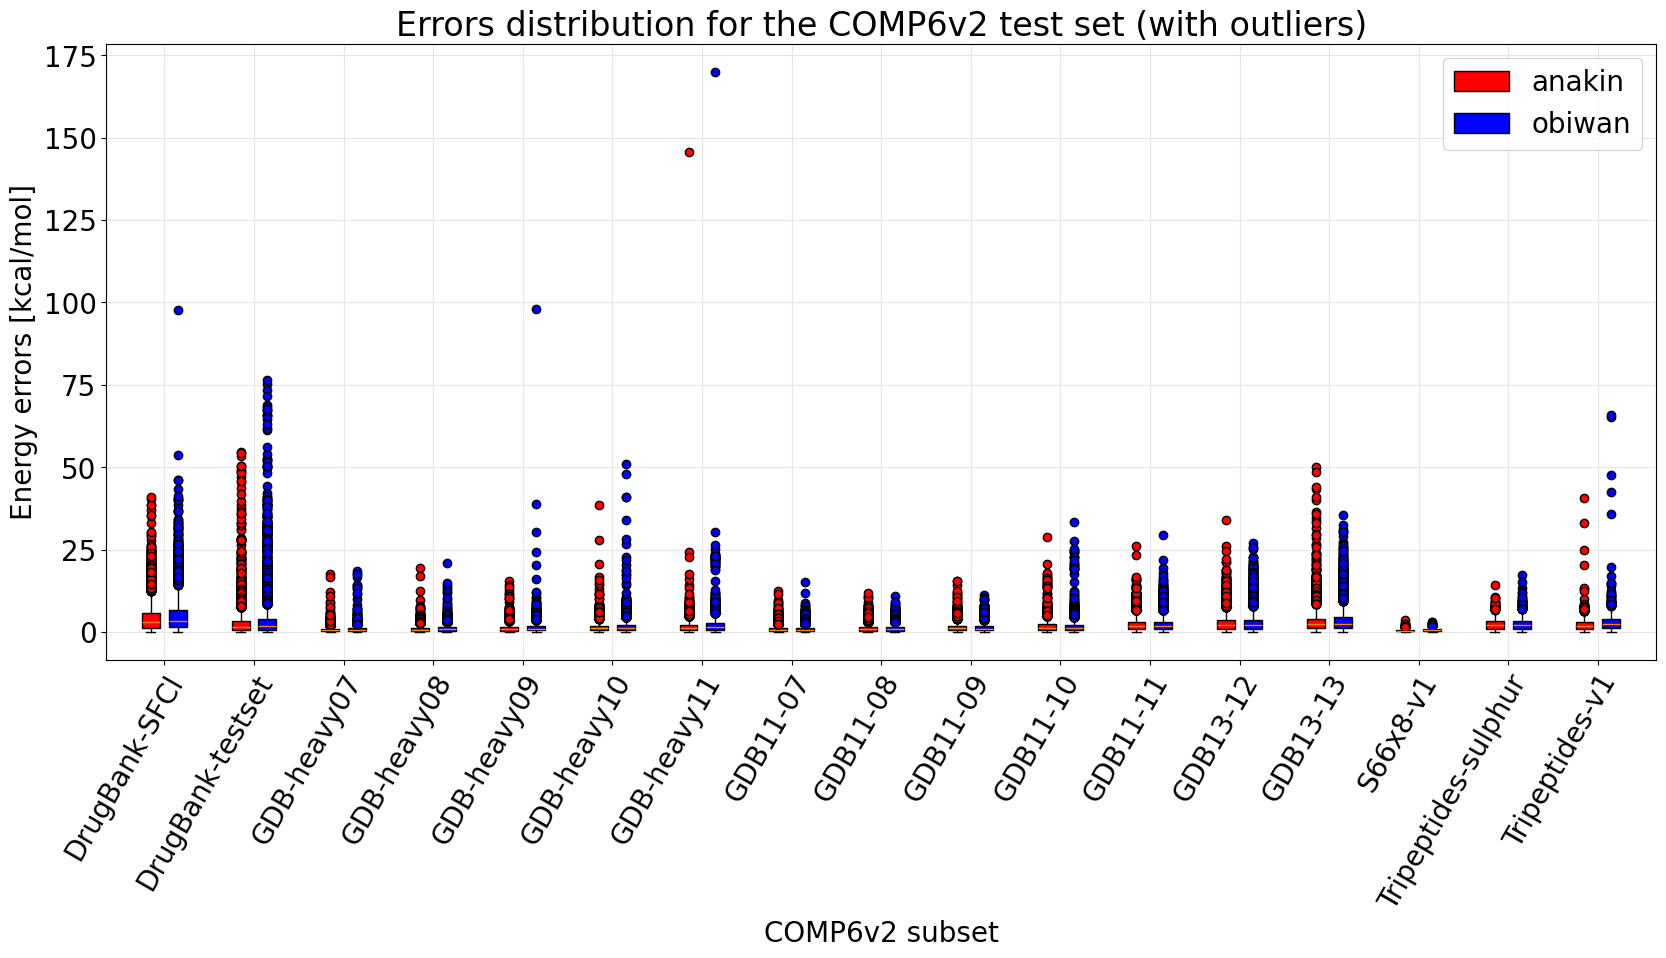

In [29]:
show_outliers = True

obi_box = plt.boxplot(obiwan_errors_dict.values(), positions=np.arange(len(obiwan_errors_dict))+0.15, widths=0.2, showfliers=show_outliers, patch_artist=True, boxprops=dict(facecolor='blue'), flierprops=dict(markerfacecolor='blue'))
ani_box = plt.boxplot(anakin_errors_dict.values(), positions=np.arange(len(anakin_errors_dict))-0.15, widths=0.2, showfliers=show_outliers, patch_artist=True, boxprops=dict(facecolor='red'), flierprops=dict(markerfacecolor='red'))

plt.xticks(np.arange(len(obiwan_errors_dict)), obiwan_errors_dict.keys(), rotation=60, ha='right', rotation_mode='anchor')

plt.xlabel('COMP6v2 subset')
plt.ylabel('Energy errors [kcal/mol]')
plt.title('Errors distribution for the COMP6v2 test set (with outliers)')

plt.legend([ani_box["boxes"][0], obi_box["boxes"][0]], ['anakin', 'obiwan'])
plt.grid(color='0.9')

fig = plt.gcf()
fig.set_size_inches(20, 8)

In [30]:
obiwan_above_3_perc = {k: len([e for e in obiwan_errors_dict[k] if e > 3])/len(obiwan_errors_dict[k])*100
                        for k in obiwan_errors_dict}

anakin_above_3_perc = {k: len([e for e in anakin_errors_dict[k] if e > 3])/len(anakin_errors_dict[k])*100
                        for k in anakin_errors_dict}

In [37]:
obiwan_above_3_perc['model'] = 'obiwan'
anakin_above_3_perc['model'] = 'ANI-2x[0]'

In [42]:
above_3_df = pd.DataFrame([obiwan_above_3_perc, anakin_above_3_perc]).set_index('model')
above_3_df

,DrugBank-SFCl,DrugBank-testset,GDB-heavy07,GDB-heavy08,GDB-heavy09,GDB-heavy10,GDB-heavy11,GDB11-07,GDB11-08,GDB11-09,GDB11-10,GDB11-11,GDB13-12,GDB13-13,S66x8-v1,Tripeptides-sulphur,Tripeptides-v1
model,,,,,,,,,,,,,,,,,
obiwan,53.674674,32.311832,0.900000,3.422222,6.133333,11.155556,20.300000,1.766667,3.75,7.341667,12.291667,26.066838,33.991667,41.741667,0.189394,29.832474,37.953629
ANI-2x[0],49.216205,29.157635,0.833333,2.166667,4.144444,8.344444,13.744444,1.750000,3.55,8.408333,14.200000,26.452442,32.425000,38.541667,0.189394,29.961340,25.352823


## Median bars

In [33]:
obiwan_median_dict = {ds_name:np.median(obiwan_errors_dict[ds_name]) for ds_name in obiwan_errors_dict}
obiwan_median_dict["model"] = "obiwan"

anakin_median_dict = {ds_name:np.median(anakin_errors_dict[ds_name]) for ds_name in anakin_errors_dict}
anakin_median_dict["model"] = "ANI-2x[0]"

In [34]:
median_dataframe = pd.DataFrame([anakin_median_dict, obiwan_median_dict])
median_dataframe = median_dataframe[["model"] + [col for col in median_dataframe.columns if col != "model"]]

In [35]:
median_dataframe = median_dataframe.set_index('model')

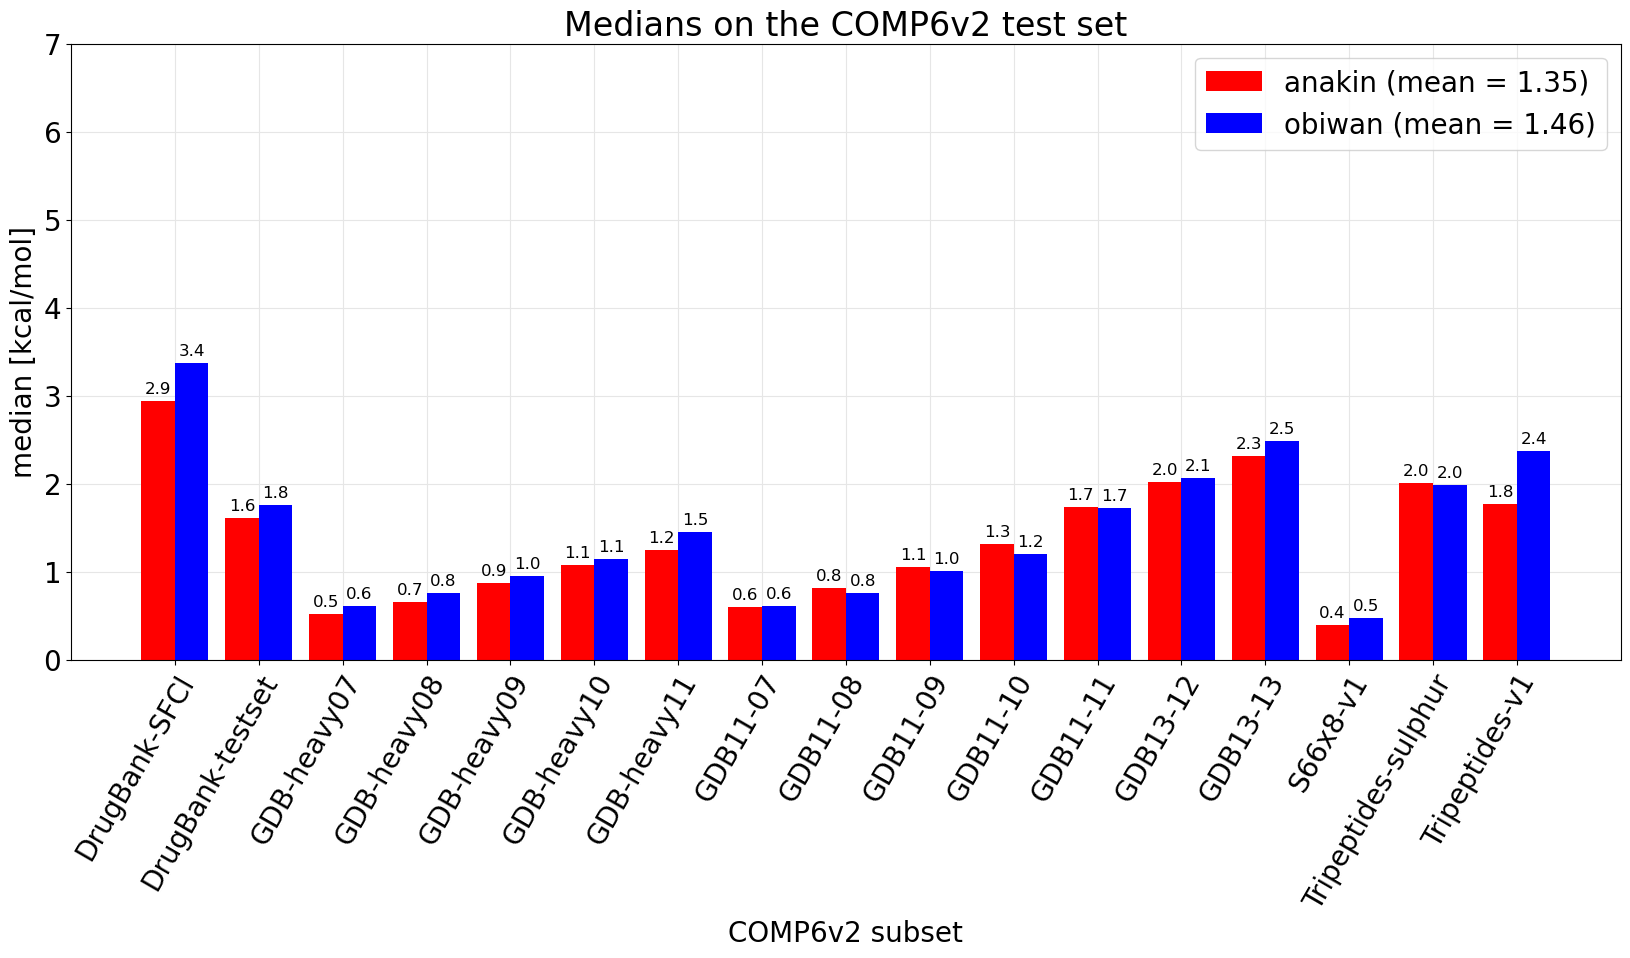

In [36]:
anakin_mean = median_dataframe.loc['ANI-2x[0]'].mean()
obiwan_mean = median_dataframe.loc['obiwan'].mean()

anakin_legend = f'anakin (mean = {anakin_mean:.2f})'
obiwan_legend = f'obiwan (mean = {obiwan_mean:.2f})'

anakin_bars = median_dataframe.loc['ANI-2x[0]'].to_numpy()
obiwan_bars = median_dataframe.loc['obiwan'].to_numpy()

x_ticks = median_dataframe.columns

plt.rc('font', size=20)

x_axis = np.arange(len(x_ticks))

plt.bar(x=x_axis-0.2, height=anakin_bars, width=0.4, label=anakin_legend, color='red', zorder=2)
plt.bar(x=x_axis+0.2, height=obiwan_bars, width=0.4, label=obiwan_legend, color='blue', zorder=2)

for i, v in enumerate(anakin_bars):
    plt.text(i-0.2, v + 0.05, f'{v:.1f}', ha='center', va='bottom', fontsize=12)

for i, v in enumerate(obiwan_bars):
    plt.text(i+0.2, v + 0.05, f'{v:.1f}', ha='center', va='bottom', fontsize=12)

plt.xticks(x_axis, x_ticks, rotation=60, ha='right', rotation_mode='anchor')

max_y = np.ceil(max_y) + 1
plt.yticks(np.arange(0, max_y, 1))

plt.xlabel('COMP6v2 subset')
plt.ylabel('median [kcal/mol]')

plt.title('Medians on the COMP6v2 test set')

plt.legend()

plt.grid(color='0.9', zorder=1)

fig = plt.gcf()
fig.set_size_inches(20, 8)